#### import libraries

In [1]:
import numpy as np
import pandas as pd 
import re
import geonamescache
import unidecode
import json

#### import all headlines for the file

In [2]:
f = open('./data/headlines.txt',"r")
headlines = f.read().splitlines()
f.close()

#### create dictionaries for countries and cities

In [3]:
gc = geonamescache.GeonamesCache()

countries = [country["name"] for country in gc.get_countries().values()]
cities = [city["name"] for city in gc.get_cities().values()]
allcountries = gc.get_countries()

#### create mappings between accented and unicode countries and city names

In [4]:
country_accent_mapping = {
    unidecode.unidecode(country): country for country in countries
}

city_accent_mapping = {
    unidecode.unidecode(city): city for city in cities
}

##### create mappings between country code and country name 

In [5]:
country_to_code = {
    allcountries[country]['name']: country for country in allcountries
}

code_to_country = {
    country: allcountries[country]['name'] for country in allcountries
}

#### sort countries and cities by name lenght

In [6]:
unaccented_cities = list(city_accent_mapping.keys())
unaccented_countries = list(country_accent_mapping.keys())

unaccented_cities.sort(key=lambda item: (-len(item), item), reverse=False)
unaccented_countries.sort(key=lambda item: (-len(item), item), reverse=False)

#### create regexes for coutries and city names

In [7]:
_cities = "|".join(unaccented_cities)
regexCity = "\\b(" + _cities + ")\\b"
compiledReCity = re.compile(regexCity)

_countries = "|".join(unaccented_countries)
regexCountry = "\\b(" + _countries + ")\\b"
compiledReCountry = re.compile(regexCountry)

#### create function extracting city and country from a headline

In [8]:
def city_and_country_from_a_headline(headline):
    
    '''
    find city name and country name in a given headline
    
    input: headline (string)
    output: mapping the headline to city(s) and/or countries (dict)
    
    '''
    
    latitude = None
    longitude = None
    population = None
    
    # country found
    country_match = compiledReCountry.search(headline)
    if country_match:
        country = country_match.group(0)
    else:
        country = None
    
    # city found
    city_match = compiledReCity.search(headline)
    if city_match:
        city = city_match.group(0)
        # look up a country based on a accented city name
        _cities = gc.get_cities_by_name(city_accent_mapping[city])
        biggestCity = {}
        for c in _cities:
            for cityKey in c:
#                 print(cityKey)
                if len(biggestCity) == 0:
                    biggestCity = c[cityKey]
                else:
                    if c[cityKey]['population'] > biggestCity['population']:
                        biggestCity = c[cityKey] 
#         print(biggestCity)
        if not country_match:
            country = code_to_country[biggestCity['countrycode']]
        latitude = biggestCity['latitude']
        longitude = biggestCity['longitude']
        population = biggestCity['population']
    else:
        city = None
    
    return dict(headline=headline, country=country, city=city, latitude=latitude, longitude=longitude, population=population)    

#### test to see results for first 100 headlines

In [9]:
headline_cities_and_countries = [
    city_and_country_from_a_headline(headline) for headline in headlines
]
headline_cities_and_countries[-100:]

[{'headline': 'Zika case reported in Limoeiro',
  'country': 'Brazil',
  'city': 'Limoeiro',
  'latitude': -7.87472,
  'longitude': -35.45028,
  'population': 42328},
 {'headline': 'Ibadan tests new cure for Malaria',
  'country': 'Nigeria',
  'city': 'Ibadan',
  'latitude': 7.37756,
  'longitude': 3.90591,
  'population': 3565108},
 {'headline': 'Gonorrhea has Arrived in Avon Lake',
  'country': 'United States',
  'city': 'Avon Lake',
  'latitude': 41.50532,
  'longitude': -82.0282,
  'population': 23453},
 {'headline': 'Pneumonia has not Left Kinshasa',
  'country': 'Democratic Republic of the Congo',
  'city': 'Kinshasa',
  'latitude': -4.32758,
  'longitude': 15.31357,
  'population': 7785965},
 {'headline': 'Respiratory Syncytial Virus Hits Henderson',
  'country': 'United States',
  'city': 'Henderson',
  'latitude': 36.0397,
  'longitude': -114.98194,
  'population': 285667},
 {'headline': 'More Zika patients reported in Lakeland',
  'country': 'United States',
  'city': 'Lakela

##### save to  json

In [10]:
save_file = "./data/headline_cities_and_countries.json"
with open(save_file, "w") as fout:
    fout.write(json.dumps(headline_cities_and_countries))

#### save mappings

In [11]:
with open("./data/country_accent_mapping.json", "w") as fout:
    fout.write(json.dumps(country_accent_mapping))
with open("./data/city_accent_mapping.json", "w") as fout:
    fout.write(json.dumps(city_accent_mapping))
with open("./data/country_to_code.json", "w") as fout:
    fout.write(json.dumps(country_to_code))
with open("./data/code_to_country.json", "w") as fout:
    fout.write(json.dumps(code_to_country))

#### read df from json and print 10 first rows

In [12]:
import pandas as pd

data = pd.read_json("./data/headline_cities_and_countries.json")
data = data.replace({None: np.nan})

data.head(10)

,headline,country,city,latitude,longitude,population
0,Zika Outbreak Hits Miami,United States,Miami,25.77427,-80.19366,441003.0
1,Could Zika Reach New York City?,United States,New York City,40.71427,-74.00597,8175133.0
2,First Case of Zika in Miami Beach,United States,Miami Beach,25.79065,-80.13005,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,-8.05389,-34.88111,1478098.0
4,Dallas man comes down with case of Zika,United States,Dallas,32.78306,-96.80667,1300092.0
5,Trinidad confirms first Zika case,Bolivia,Trinidad,-14.83333,-64.90000,84259.0
6,Zika Concerns are Spreading in Houston,United States,Houston,29.76328,-95.36327,2296224.0
7,Geneve Scientists Battle to Find Cure,Switzerland,Geneve,46.20222,6.14569,183981.0
8,The CDC in Atlanta is Growing Worried,United States,Atlanta,33.74900,-84.38798,463878.0
9,Zika Infested Monkeys in Sao Paulo,Brazil,Sao Paulo,-23.54750,-46.63611,10021295.0


#### run some stats on data

In [13]:
data

,headline,country,city,latitude,longitude,population
0,Zika Outbreak Hits Miami,United States,Miami,25.77427,-80.19366,441003.0
1,Could Zika Reach New York City?,United States,New York City,40.71427,-74.00597,8175133.0
2,First Case of Zika in Miami Beach,United States,Miami Beach,25.79065,-80.13005,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,-8.05389,-34.88111,1478098.0
4,Dallas man comes down with case of Zika,United States,Dallas,32.78306,-96.80667,1300092.0
5,Trinidad confirms first Zika case,Bolivia,Trinidad,-14.83333,-64.90000,84259.0
6,Zika Concerns are Spreading in Houston,United States,Houston,29.76328,-95.36327,2296224.0
7,Geneve Scientists Battle to Find Cure,Switzerland,Geneve,46.20222,6.14569,183981.0
8,The CDC in Atlanta is Growing Worried,United States,Atlanta,33.74900,-84.38798,463878.0
9,Zika Infested Monkeys in Sao Paulo,Brazil,Sao Paulo,-23.54750,-46.63611,10021295.0


In [14]:
data["headline"].value_counts().sort_values().tail()

Zika arrives in Belmopan                                           1
How to Avoid Rhinovirus in Plainfield                              1
Authorities are Worried about the Spread of Varicella in Clovis    1
Spanish Flu Spreading through Madrid                               2
Spanish Flu Outbreak in Lisbon                                     2
Name: headline, dtype: int64

In [15]:
print(f"There were {len(data)} rows before dropping duplicates.")
data = data.drop_duplicates()
print(f"There are {len(data)} rows after dropping duplicates.")

There were 650 rows before dropping duplicates.
There are 648 rows after dropping duplicates.


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 649
Data columns (total 6 columns):
headline      648 non-null object
country       606 non-null object
city          606 non-null object
latitude      606 non-null float64
longitude     606 non-null float64
population    606 non-null float64
dtypes: float64(3), object(3)
memory usage: 35.4+ KB


In [17]:
data['country'].value_counts()

United States           303
Brazil                   21
Philippines              19
United Kingdom           19
Canada                   15
                       ... 
Nepal                     1
Hong Kong                 1
Slovenia                  1
Greece                    1
United Arab Emirates      1
Name: country, Length: 94, dtype: int64

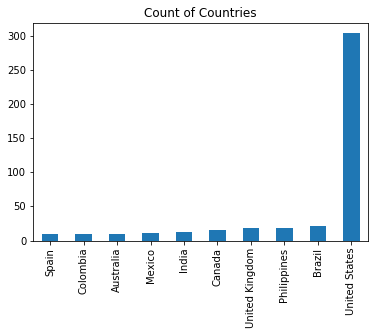

In [18]:
%matplotlib inline

_ = data['country'].value_counts().sort_values().tail(10).plot.bar(title='Count of Countries')

In [19]:
print(f'There are {data["country"].nunique()} different countries.')
print(f'There are {data["city"].nunique()} different cities.')

There are 94 different countries.
There are 573 different cities.


In [20]:
data["city"].value_counts().sort_values().tail(10)

Jefferson    2
Melbourne    2
Bedford      2
Fairfield    2
Cancun       2
Cambridge    2
Barcelona    3
Madrid       3
Monroe       4
Miami        4
Name: city, dtype: int64

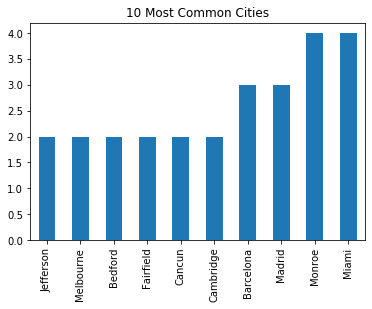

In [21]:
_ = (
    data["city"]
    .value_counts()
    .sort_values()
    .tail(10)
    .plot.bar(title="10 Most Common Cities")
)

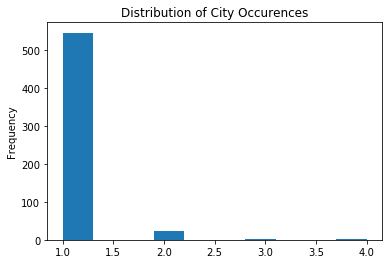

In [22]:
_ = data["city"].value_counts().plot.hist(title="Distribution of City Occurences")

#### clean data

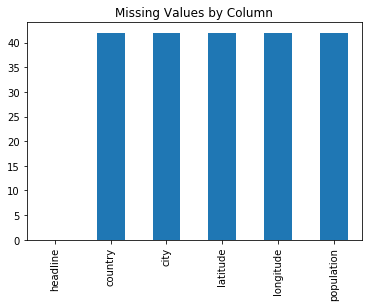

In [23]:
_ = data.isna().sum().plot.bar(title='Missing Values by Column')

In [24]:
pd.options.display.max_colwidth = 100

no_name = data[data["city"].isna()].copy()

print(f"There are {len(no_name)} headlines without a city.")

no_name

There are 42 headlines without a city.


,headline,country,city,latitude,longitude,population
17,Louisiana Zika cases up to 26,NaN,NaN,NaN,NaN,NaN
19,Zika infects pregnant woman in Cebu,NaN,NaN,NaN,NaN,NaN
48,Spanish Flu Sighted in Antigua,NaN,NaN,NaN,NaN,NaN
63,Carnival under threat in Rio De Janeiro due to Zika outbreak,NaN,NaN,NaN,NaN,NaN
73,Zika case reported in Oton,NaN,NaN,NaN,NaN,NaN
76,Hillsborough uses innovative trap against Zika 20 minutes ago,NaN,NaN,NaN,NaN,NaN
88,Maka City Experiences Influenza Outbreak,NaN,NaN,NaN,NaN,NaN
139,More Zika patients reported in Mcallen,NaN,NaN,NaN,NaN,NaN
156,West Nile Virus Outbreak in Saint Johns,NaN,NaN,NaN,NaN,NaN
233,More people in Mclean are infected with Hepatitis A every year,NaN,NaN,NaN,NaN,NaN


In [25]:
data = data.dropna(subset=['city'])

In [26]:
data

,headline,country,city,latitude,longitude,population
0,Zika Outbreak Hits Miami,United States,Miami,25.77427,-80.19366,441003.0
1,Could Zika Reach New York City?,United States,New York City,40.71427,-74.00597,8175133.0
2,First Case of Zika in Miami Beach,United States,Miami Beach,25.79065,-80.13005,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,-8.05389,-34.88111,1478098.0
4,Dallas man comes down with case of Zika,United States,Dallas,32.78306,-96.80667,1300092.0
5,Trinidad confirms first Zika case,Bolivia,Trinidad,-14.83333,-64.90000,84259.0
6,Zika Concerns are Spreading in Houston,United States,Houston,29.76328,-95.36327,2296224.0
7,Geneve Scientists Battle to Find Cure,Switzerland,Geneve,46.20222,6.14569,183981.0
8,The CDC in Atlanta is Growing Worried,United States,Atlanta,33.74900,-84.38798,463878.0
9,Zika Infested Monkeys in Sao Paulo,Brazil,Sao Paulo,-23.54750,-46.63611,10021295.0


In [27]:
print(f'We have the city locations for {len(data)} cities.')

We have the city locations for 606 cities.


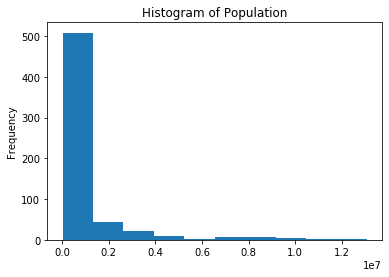

In [28]:
_ = data['population'].plot.hist(title='Histogram of Population')

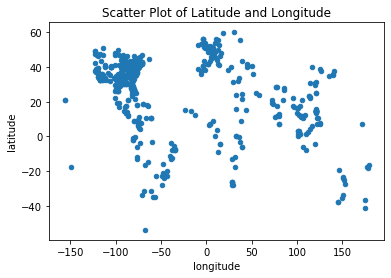

In [29]:
_ = data.plot.scatter(
    x="longitude", y="latitude", title="Scatter Plot of Latitude and Longitude"
)